# NLP Project: Prediction of product success on Amazon
### ENSAE Paris
### Authors: Yann Boulo and Tristan Loisel
### Professor: Benjamin Muller

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import gzip
from urllib.request import urlopen
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

# Data import

We import two datasets:


*   one containing **all the reviews** and overall ratings of products categorized as video games by amazon
*   the second one containing all **data about this products** (title, description, price...)



In [57]:
! wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Video_Games.json.gz

! wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Video_Games.json.gz


--2020-04-12 08:21:24--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Video_Games.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522823613 (499M) [application/octet-stream]
Saving to: ‘Video_Games.json.gz.1’

Video_Games.json.gz 100%[===================>] 498.60M  10.3MB/s    in 48s     

2020-04-12 08:22:13 (10.3 MB/s) - ‘Video_Games.json.gz.1’ saved [522823613/522823613]

--2020-04-12 08:22:14--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Video_Games.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80222877 (77M) [application/octet-stream]
Saving to: ‘meta_Video_Games.json.gz.1’

meta_Video_Games.js 100%[===================>]  76.51M  10.3MB/s

In [0]:
def get_data(file):
  data = []
  with gzip.open(file) as f:
      for l in f:
          data.append(json.loads(l.strip()))
  return(pd.DataFrame.from_dict(data))

reviews = get_data('Video_Games.json.gz')
metadata = get_data('meta_Video_Games.json.gz')

# Data cleaning 



We first delete the columns we deemed useless in the metadata (i.e. data about the products)


In [0]:
del metadata["also_buy"]
del metadata["also_view"]
del metadata["similar_item"]
del metadata["feature"]
del metadata["details"]
del metadata["tech1"]
del metadata["tech2"]
del metadata["main_cat"]

Then we delete NaNs in date and price columns, as we need them to be clean. The date in question is the launching date of the product on amazon.





In [0]:
clean_metadata = metadata.dropna(subset=['date','price']) 


And we only keep one line for each product

In [0]:
clean_metadata = clean_metadata.drop_duplicates(subset='asin', keep="last")

We clean the prices in order to turn them into numbers

In [0]:
import re
indexes = clean_metadata.index.values.tolist()
clean_prices = np.empty(len(clean_metadata))
clean_prices[:]= np.NaN
j=0
for i in indexes:
  s = clean_metadata["price"][i]

  price = re.sub('\D', '', s[:10])
  clean_prices[j] = float(price)/100.0

  j+=1

clean_metadata.insert(7, "clean_price", clean_prices, True)


We convert the dates to Unix time:

In [63]:
import time
import datetime
products_dates_unix = dict()
max_date = 0
date = ""
errors =0
for i in clean_metadata.index.values.tolist():
  string_date = clean_metadata["date"][i]
  asin = clean_metadata["asin"][i]
  try:
    products_dates_unix[asin] =time.mktime(datetime.datetime.strptime(string_date, '%B %d, %Y').timetuple())
    if products_dates_unix[asin] > max_date:
      products_dates_unix[asin] > max_date
      date = string_date
  except ValueError:
    errors +=1
print("Proportion of errors: " + str(errors/len(clean_metadata)))

Proportion of errors: 0.003787878787878788


We create a column containing, for each product, the number of 5/5 ratings it obtained in the four years following its release. It will enable us to create the variable we want to predict. 

N.B: we chose four years because the latest products in this data were released in 2016. We also tried two and three years but it led to a lower performance of the feature.

The high proportion of KeyError comes from the fact that many reviews are the ones of products absent from our clean metadata because they had incomplete information (NaNs).

In [64]:
ratings = reviews[["asin","overall","reviewText","unixReviewTime"]]

ratings_per_product = defaultdict(lambda:[])
reviews_per_product = defaultdict(lambda:[])


for i in tqdm(range(len(ratings))):
  try:
    id_object = ratings["asin"][i]
    rating_date = ratings["unixReviewTime"][i]

    product_date = products_dates_unix[id_object]
    if product_date + 4*365*24*3600 > rating_date : #we only take the reviews which appaear less 
                                                    #than four years after the release of the product
      ratings_per_product[id_object].append(ratings["overall"][i])
      reviews_per_product[id_object].append(ratings["reviewText"][i])
  except KeyError: # There are some errors due to the fact that metacleandata does not countain all products
    ()


number_fives = dict() # In this variable we write the number of overall ratings equal to five within the reviews

for obj in ratings_per_product: 
  ratings_per_product[obj] = np.array(ratings_per_product[obj])
  number_fives[obj] = np.count_nonzero(ratings_per_product[obj] - 5.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


We then add the number of 5/5 ratings (in the four years after the release) as a column in our dataframe

In [65]:
nb_fives_column = np.empty(len(clean_metadata))
nb_fives_column[:]= np.NaN
j=0
errors=0
for i in indexes:
    try:
        nb_fives_column[j] = number_fives[clean_metadata["asin"][i]]
    except KeyError:
        nb_fives_column[j]=0
        errors +=1
    j+=1
print("Proportion of errors: " + str(errors/len(indexes)))
clean_metadata.insert(2, "nb_fives", nb_fives_column, True)

Proportion of errors: 0.07196969696969698


We split the data into two separate sets:

- data_for_features will be used as an environment to compute some "external"/macro features (brand score and doc2vec nearest neighbors)

- data_for_model on which we will train and test our model

In [0]:
from sklearn.model_selection import train_test_split
seed = 10
data_for_features,data_for_model,_,_ = train_test_split(clean_metadata, clean_metadata, test_size=int(len(clean_metadata)/2), random_state = seed)
# To split the data randomly, we can simply use the sklearn train_test_split function

# Creation of our features

In [67]:
#this step is just a quick tokenization
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Description/Title length

Our first features will simply be the length of a product's title (ie denomination) and description (given to Amazon by the manufacture)

In [0]:
def compute_length_feature(data):
  titles = list(data["title"])
  descriptions = list(data["description"])
  length_title = np.zeros(len(data))
  length_description = np.zeros(len(data))
  for i in tqdm(range(len(data))):
    length_title[i] = len(str(titles[i]))
    length_description[i] = len(str(descriptions[i]))
  return((length_title,length_description))

In [69]:
X_title_length,X_description_length = compute_length_feature(data_for_model)
# X_something designate an array containing the feature "something" for each product

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## Availability of a product's picture

For a given product, this feature is worth 1 if a picture of this product is available on Amazon, and 0 otherwise.

In [0]:
X_images = np.zeros(len(data_for_model))
images = list(data_for_model["image"])
for i in range(len(data_for_model)):
  if str(images[i]) == "nan":
    X_images[i]=1


## Word2Vec similarity (descriptions)

This feature works as follows:
- we load a pre-trained word2vec model
- we choose a reference word we identified as relevant in this context: "garantee", "quality", "best", "delivery" etc.
- for a given description, we compute a score according to the similarity its words have with our chosen word

We compute this feature for several key-words.

We load a pre-trained model of word2vec in order to computer some similarity feature from the descriptions.

In [71]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [72]:
import gensim

# Load pretrained model 
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Computed feature: highest word similarity between given words ("guarantee","best"...) and the words of the description 

In [73]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

def compute_similarity_features_descriptions(descriptions,ref_words):
  similarity_features = np.array([[0.0 for i in range(len(ref_words))] for j in range(len(descriptions))])
  stop_words = stopwords.words('english') 
  description_index=0
  for d in tqdm(descriptions):
    if type(d)==list:
      d_list = word_tokenize(d[0]) #tokenization 
      d_list = [w for w in d_list if not w in stop_words]
      ref_index=0
      for ref_word in ref_words:
        maxscore = 0
        for w in d_list:
          try:
            score = word2vec_model.similarity(w,ref_word)/len(d_list) #similarity computation
          except KeyError:
            ()
          maxscore = score if maxscore < score else maxscore
        similarity_features[description_index,ref_index]+=maxscore
        ref_index +=1
    description_index+=1

  return(similarity_features) #we normalize the output such that it is a real number in [0,1]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [74]:
X_similarity_w2v = compute_similarity_features_descriptions(data_for_model["description"],["guarantee","quality","best","new","delivery"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Word2vec similarity (for reviews, not used in the final model but efficient)



Same feature as the one computed for the descriptions, except that there are several reviews per product (whereas we only have one description). Therefore, we decided to average the highest word similarity across the reviews.

Also, it is important to notice that this feature serves a slightly different purpose that our main one. 

Our main purpose is to predict, at a product's launching time, how much success it is likely to have. For this main purpose, the reviews are irrelevant because they come from "the future".

However, looking at the reviews allows to study the predictability of a product's score given its characteritics and reviews. Given the little supplementary works it required to adapt our former feature to reviews, we thought it was worth to do it.

In [0]:
# def compute_similarity_features_reviews(id_products,ref_words):
#     similarity_features = np.array([[0.0 for i in range(len(ref_words))] for j in range(len(id_products))])
#     stop_words = stopwords.words('english') 
#     data_index=0
#     for i in tqdm(range(len(id_products))):
#     #tokenization 
#         id_object = id_products[i]
#         reviews_list = reviews_per_product[id_object][:5]
#         for r in reviews_list:
#             if type(r)==str:
#                 r_list = word_tokenize(r)
#                 r_list = [w for w in r_list if not w in stop_words]
#                 ref_index=0
#                 for ref_word in ref_words:
#                     for w in r_list:
#                         maxscore = 0
#                         try:
#                           #similarity
#                           score = word2vec_model.similarity(w,ref_word)/(len(r_list)*len(reviews_list))
#                         except KeyError:
#                           ()
#                         maxscore = score if maxscore < score else maxscore
#                     similarity_features[data_index,ref_index]+=maxscore
#                     ref_index +=1
#         data_index+=1

#     return(np.array(similarity_features)) #we normalize the output such that it is a real number in [0,1]
        
  

In [0]:
# X_similarity_reviews_w2v = compute_similarity_features_reviews(list(data_for_model["asin"]),["guarantee","quality","best","awesome","game","new","essential","delivery"])

## Brand score (computed on data_for_features to avoid overfitting)

We have some information about the product's brands. This feature is the average number of 5/5 ratings obtained by all the products of data_for_features within a given brand.

In [76]:
brands = set(list(clean_metadata["brand"]))

brand_scores = dict()
for b in brands:
  brand_scores[b]=[]
data_for_features_indexes = data_for_features.index.values.tolist()

for i in data_for_features_indexes:
  try:
    brand_scores[data_for_features["brand"][i]].append(data_for_features["nb_fives"][i])
    
  except KeyError:
    ()
for b in brands:
  brand_scores[b]=np.mean(np.array(brand_scores[b]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
def compute_brand_feature(data):
  brand_feature = np.zeros(len(data))
  brands_list = list(data["brand"])
  i=0
  for b in tqdm(brands_list):
    brand_feature[i]=brand_scores[b]
    i+=1
  return(brand_feature)

X_brand_score = compute_brand_feature(data_for_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


## Nearest neighbors with Doc2Vec

In this part, we train a doc2vec model on the set of descriptions.

Note that we made the choice not to suppress from our dataset the products with an empty description field. Instead, we separate them from the the others products of data_for_features and just give them the value -1 as a feature.

Then, we train a doc2vec model on the no-empty descriptions from data_for_features. We thus obtain a representation of our descriptions as vectors. We then take, for a given description, the 10 nearest description and the sum of the associated product's score. By score, we mean our objective: 1 if a given product has enouhg 5/5 ratings and 0 otherwise.



Imports:

In [0]:
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import Doc2Vec

Data selection before training (we delete NaNs) to get a sub-dataset of products with non-empty descriptions.


In [0]:
doc2vec_indexes_to_drop = np.array([i for i in data_for_features.index.values.tolist() if type(data_for_features["description"][i])!=list])
doc2vec_train_data = data_for_features.drop(doc2vec_indexes_to_drop)

tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) for i, _d in enumerate(doc2vec_train_data["description"])]

Doc2Vec model training:

In [80]:
max_epochs = 10
vec_size = 20
alpha = 0.025

doc2vec_model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
doc2vec_model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    doc2vec_model.train(tagged_data,
                total_examples=doc2vec_model.corpus_count,
                epochs=doc2vec_model.iter)
    # decrease the learning rate
    doc2vec_model.alpha -= 0.0002
    # fix the learning rate, no decay
    doc2vec_model.min_alpha = doc2vec_model.alpha

doc2vec_model.save("d2v.model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Computation of the product scores in our sub-dataset. These scores are deterministic and will be needed to compute, for a given description, the scores corresponding to its 10 nearest neighbors in our doc2vec model.

In [0]:
labels =  np.array(list(doc2vec_train_data["nb_fives"]))
for i in range(len(labels)):
  if labels[i]>2:
    labels[i]=1
  else:
    labels[i]=0

Finally, we compute the feature: for a given product: 

1.   if this product's description is empty, the feature is worth -1
2.   else, we take the 10 products the descriptions of which are the nearest of its description and we sum these products scores to get our feature.



In [82]:
def compute_doc2vec_feature_description(data):
  
  doc2vec_feature = np.zeros(len(data))
  j=0
  
  for idx in tqdm(data.index.values.tolist()):
    description_i = data["description"][idx]
    if not type(description_i)==list:
      doc2vec_feature[j] = -1
    else:
      test_data = word_tokenize(str(description_i).lower())
      v_idx = doc2vec_model.infer_vector(test_data)
      nearest_neighbors = [int(tup[0]) for tup in doc2vec_model.docvecs.most_similar([v_idx],topn = 10 )]
      doc2vec_feature[j] = labels[nearest_neighbors].sum()
    j+=1
  return(doc2vec_feature)

doc2vec_feature_descriptions = compute_doc2vec_feature_description(data_for_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Same feature with the product title (ie denomination)

In [0]:
tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) for i, _d in enumerate(data_for_features["title"])]

In [84]:
max_epochs = 10
vec_size = 20
alpha = 0.025

doc2vec_model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
doc2vec_model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    doc2vec_model.train(tagged_data,
                total_examples=doc2vec_model.corpus_count,
                epochs=doc2vec_model.iter)
    # decrease the learning rate
    doc2vec_model.alpha -= 0.0002
    # fix the learning rate, no decay
    doc2vec_model.min_alpha = doc2vec_model.alpha

doc2vec_model.save("d2v.model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
labels =  np.array(list(data_for_features["nb_fives"]))
for i in range(len(labels)):
  if labels[i]>2:
    labels[i]=1
  else:
    labels[i]=0

In [86]:
def compute_doc2vec_feature_title(data):

  doc2vec_feature = np.zeros(len(data))
  j=0
  for idx in tqdm(data.index.values.tolist()):

    title_i = data["title"][idx]

    if not type(title_i)==str:
      doc2vec_feature[j] = -1
    else:
      test_data = word_tokenize(str(title_i).lower())
      v_idx = doc2vec_model.infer_vector(test_data)
      nearest_neighbors = [int(tup[0]) for tup in doc2vec_model.docvecs.most_similar([v_idx],topn = 10 )]
      doc2vec_feature[j] = labels[nearest_neighbors].sum()
    j+=1
  return(doc2vec_feature)

doc2vec_feature_titles = compute_doc2vec_feature_title(data_for_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Price

In [0]:
X_price = data_for_model["clean_price"]

# Design of a prediction model

We use an XGBoost prediction model. We train it on data_for_features and test it on data_for_model.

Imports:

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

We transpose our similarity estimators for technical considerations.

In [0]:
X_similarity_w2v = np.transpose(X_similarity_w2v)
#X_similarity_reviews_w2v = np.transpose(X_similarity_reviews_w2v)

## Feature selection:

Below, the features with a "True" value are going to be tested for our model.

In [0]:
features = {"Image":True,
            "doc2vec_nearest_neighbors_titles":True,
            "doc2vec_nearest_neighbors_descriptions":True,
            "Title_length":True,
            "Description_length":True,
            "Brand_score":True,
            "Price":True,
            "word2vec_similarity_to_guarantee":True,
            "word2vec_similarity_to_quality":True,
            "word2vec_similarity_to_best":True,
            "word2vec_similarity_to_new":True,
            "word2vec_similarity_to_delivery":True

}



In what folows, X_all contains every feature. X contains only the features we selected above. Below, do some technical preparatives and set the size of our testing set relatively to our dataset size.

In [0]:
X_all = np.vstack((X_images, doc2vec_feature_titles,doc2vec_feature_descriptions,X_title_length,X_description_length,X_brand_score,X_price))

X_all = np.vstack((X_all, X_similarity_w2v))
#X_all = np.vstack((X_all, X_similarity_reviews_w2v))
X_all = np.transpose(X_all)

In [0]:

all_columns = ["Image","doc2vec_nearest_neighbors_titles",
"doc2vec_nearest_neighbors_descriptions","Title_length",
"Description_length","Brand_score","Price",
"word2vec_similarity_to_guarantee",
"word2vec_similarity_to_quality",
"word2vec_similarity_to_best",
"word2vec_similarity_to_new",
"word2vec_similarity_to_delivery"]

X=np.empty(len(data_for_model))
columns = []
X_empty = True
i=0
for c in all_columns:
  if features[c]:
    columns.append(c)
    if X_empty:
      X = X_all[:,i]
      X_empty = False
    else:
      X = np.vstack((X,X_all[:,i]))
      
  i+=1
X=X.transpose()
X = pd.DataFrame(data = X,columns = columns )

Y = np.array(list(data_for_model["nb_fives"]))
for i in range(len(Y)):
  if Y[i]>2:
    Y[i]=1
  else:
    Y[i]=0


test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state = 7) 

In the next cell, we compute the proportion of products whose score is 1. It gives in fact the correction rate of the constant estimator which always predict 1. It will be a good reference to assert the quality of our estimator.

In [124]:
# Proportion of labels equal to 1
np.sum(Y)/len(Y)

# This proportion must be close to 0.50, else the best trivial predictor 
# (either the one always equal to 0 or the one always equal to 1) would be difficult to outperform

0.47107438016528924

# Definition, training and prediction of the model

In [125]:
# fit model to training data
model = XGBClassifier(max_depth = 3, learning_rate = 0.1,n_estimators=100, objective = 'binary:logistic')

model.fit(X_train, Y_train)

# make predictions for test data
Y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_sc = f1_score(Y_test, Y_pred)
print("f1-score: %.2f%%" % (f1_sc*100.0))

Accuracy: 75.92%
f1-score: 74.45%


# Features importance

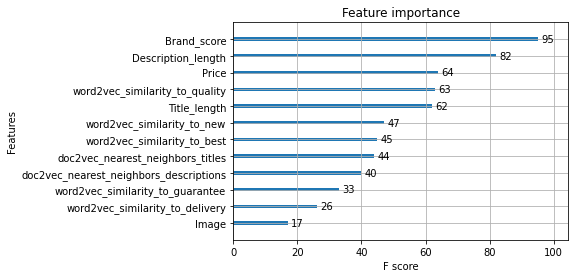

In [126]:
import xgboost as xgb

xgb.plot_importance(model)

We are surprised the presence of a picture is the least important feature. We thus check how many picture have a picture. We find that about 17% of the procucts have a picture, meaning that the feature concerns a minority of products and thus have little importance.

In [127]:
np.sum(X_images)/len(X_images)

0.16804407713498623

# Graphic representation of the model

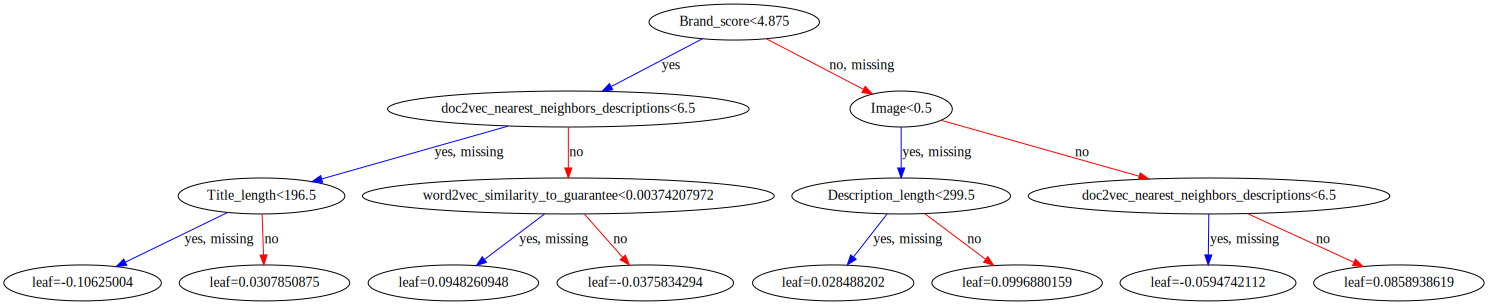

In [128]:
xgb.to_graphviz(model, num_trees=2)


# Result of the prediction model ***using only textual features***

## Feature selection: we keep only textual features

Below, the features with a "True" value are going to be tested for our model.
We give a "False" value to all features using the reviews because we remind the reader that our main objective is to build an estimator predicting a product's success only from the information avalaible before its launching time, of which reviews are not a part of.

In [0]:
features = {"Image":False,
            "doc2vec_nearest_neighbors_titles":True,
            "doc2vec_nearest_neighbors_descriptions":True,
            "Title_length":False,
            "Description_length":False,
            "Brand_score":False,
            "Price":False,
            "word2vec_similarity_to_guarantee":True,
            "word2vec_similarity_to_quality":True,
            "word2vec_similarity_to_best":True,
            "word2vec_similarity_to_new":True,
            "word2vec_similarity_to_delivery":True

}


In what folows, X_all contains every feature. X contains only the features we selected above. Below, do some technical preparatives and set the size of our testing set relatively to our dataset size.

In [0]:
X_all = np.vstack((X_images, doc2vec_feature_titles,doc2vec_feature_descriptions,X_title_length,X_description_length,X_brand_score,X_price))

X_all = np.vstack((X_all, X_similarity_w2v))
X_all = np.transpose(X_all)

In [0]:

all_columns = ["Image","doc2vec_nearest_neighbors_titles",
"doc2vec_nearest_neighbors_descriptions","Title_length",
"Description_length","Brand_score","Price",
"word2vec_similarity_to_guarantee",
"word2vec_similarity_to_quality",
"word2vec_similarity_to_best",
"word2vec_similarity_to_new",
"word2vec_similarity_to_delivery"]

X=np.empty(len(data_for_model))
columns = []
X_empty = True
i=0
for c in all_columns:
  if features[c]:
    columns.append(c)
    if X_empty:
      X = X_all[:,i]
      X_empty = False
    else:
      X = np.vstack((X,X_all[:,i]))
      
  i+=1
X=X.transpose()
X = pd.DataFrame(data = X,columns = columns )

Y = np.array(list(data_for_model["nb_fives"]))
for i in range(len(Y)):
  if Y[i]>2:
    Y[i]=1
  else:
    Y[i]=0


test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state = 7)

In the next cell, we compute the proportion of products whose score is 0. It gives in fact the correction rate of the constant estimator which always predict 0. It will be a good reference to assert the quality of our estimator.

In [132]:
# Proportion of labels equal to 1
np.sum(Y)/len(Y)

# This proportion must be close to 0.50, else the best trivial predictor 
# (either the one always equal to 0 or the one always equal to 1) would be difficult to outperform

0.47107438016528924

# Definition, training and prediction of the model

In [133]:
# fit model to training data
textual_model = XGBClassifier(max_depth = 3, learning_rate = 0.1,n_estimators=100, objective = 'binary:logistic')

textual_model.fit(X_train, Y_train)

# make predictions for test data
Y_pred = textual_model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_sc = f1_score(Y_test, Y_pred)
print("f1-score: %.2f%%" % (f1_sc*100.0))

Accuracy: 61.70%
f1-score: 57.72%


# A greedy algorithm for feature selection

Here we try to find the best features with a simple algorithm:

We start with a feature we identified as always performant which is the brand score. From a qualitative point of view, it seems relevant that the brand is part of our greedy estimator because it gives an information intuitively relevant and independant from the others features. For each other feature, we train and evaluate the model, and we keep the one feature which gives the best accuracy. We now have two features and start again this procedure, until the accuracy does not increase any more. It must be run several times, in order not to overfit the data.

We used this algorithm to select the features present in this notebook. The features we rejected were for instance word2vec similarity features with words such as "essential", "game"....

In [134]:
nb_features = 12
T = [False for i in range(nb_features)] # Table containing True when the corresponding feature is selected, else False
T[0]=True # We know that the brand score is our best feature
best_accuracy = 0
improvement = True
while improvement: #while the accuracy can be improved
  features_to_try = [i for i in range(nb_features) if not T[i]]
  best_feature = 0
  best_accuracy_temp = 0
  for i in features_to_try :
    T[i]=True

    features = {"Brand_score":T[0],
            "Image":T[1],
            "doc2vec_nearest_neighbors_titles":T[2],
            "doc2vec_nearest_neighbors_descriptions":T[3],
            "Title_length":T[4],
            "Description_length":T[5],
            "Price":T[6],
            "word2vec_similarity_to_guarantee":T[7],
            "word2vec_similarity_to_quality":T[8],
            "word2vec_similarity_to_best":T[9],
            "word2vec_similarity_to_new":T[10],
            "word2vec_similarity_to_delivery":T[11]

      }

    X=np.empty(len(data_for_model))
    columns = []
    X_empty = True
    j=0
    for c in all_columns:
      if features[c]:
        columns.append(c)
        if X_empty:
          X = X_all[:,j]
          X_empty = False
        else:
          X = np.vstack((X,X_all[:,j]))     
      j+=1
    X=X.transpose()
    X = pd.DataFrame(data = X,columns = columns)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    model = XGBClassifier(max_depth = 3, learning_rate = 0.1,n_estimators=100, objective = 'binary:logistic')

    model.fit(X_train, Y_train)

    # make predictions for test data
    Y_pred = model.predict(X_test)

    # evaluate predictions
    accuracy_temp = accuracy_score(Y_test, Y_pred)
    if best_accuracy_temp < accuracy_temp:
      best_accuracy_temp = accuracy_temp
      best_feature = i
    T[i]=False
  if best_accuracy_temp > best_accuracy:
    best_accuracy = best_accuracy_temp
  else: 
    improvement = False
  T[best_feature]=True
  accuracy = best_accuracy_temp
  print("Selected feature: " + str(best_feature))
  print("accuracy = " + str(best_accuracy))

best_T = T
print("The best selection of features is given by this table: " + str(best_T))

Selected feature: 4
accuracy = 0.7729357798165137
Selected feature: 10
accuracy = 0.786697247706422
Selected feature: 9
accuracy = 0.786697247706422
The best selection of features is given by this table: [True, False, False, False, True, False, False, False, False, True, True, False]


In [135]:
best_T # The best features are given by this table

[True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False]